In [1]:
import os, csv
from pathlib import Path
import pandas as pd
import nibabel as nib
import ipywidgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import nilearn.plotting
from IPython.display import display, clear_output
from ipywidgets import widgets, interact, interactive
import numpy as np
import regtricks as rt
from nibabel import nifti1
from PIL import Image
from nibabel.viewers import OrthoSlicer3D
from nilearn import datasets, surface

%matplotlib widget

In [2]:
# user specified variables
subject_filename = 'sub-1267031'
oxasl_filename = r'oxasl_vol'

# Strutural Space

## T1w Image

In [3]:
t1w_filename = 'struc.nii.gz'
t1_brain_filename = 'brain.nii.gz'
gm_pv_filename = 'gm_pv.nii.gz'
wm_pv_filename = 'wm_pv.nii.gz'
csf_pv_filename = 'csf_pv.nii.gz'
t1_brain_mask_filename = 'brain_mask.nii.gz'
gm_mask_filename = 'gm_seg.nii.gz'
wm_mask_filename = 'wm_seg.nii.gz'
csf_mask_filename = 'csf_seg.nii.gz'

subject_path = os.path.join(r'D:\onedrive\OneDrive - The University of Nottingham\thesis\QC_report', subject_filename)
oxasl_path = os.path.join(subject_path, oxasl_filename)

t1w_path = os.path.join(oxasl_path, 'structural', t1w_filename)
t1_brain_path = os.path.join(oxasl_path, 'structural', t1_brain_filename)
gm_pv_path = os.path.join(oxasl_path, 'structural', gm_pv_filename)
wm_pv_path = os.path.join(oxasl_path, 'structural', wm_pv_filename)
csf_pv_path = os.path.join(oxasl_path, 'structural', csf_pv_filename)

t1_brain_mask_path = os.path.join(oxasl_path, 'structural', t1_brain_mask_filename)
gm_mask_path = os.path.join(oxasl_path, 'structural', gm_mask_filename)
wm_mask_path = os.path.join(oxasl_path, 'structural', wm_mask_filename)
csf_mask_path = os.path.join(oxasl_path, 'structural', csf_mask_filename)


t1_img = nib.load(t1w_path)
t1_data = t1_img.get_fdata()
t1_dims = t1_img.shape



cbf_filename = 'perfusion.nii.gz'
asl_gm_pv_filename = 'gm_pv_asl.nii.gz'
asl_wm_pv_filename = 'wm_pv_asl.nii.gz'
asl_csf_pv_filename = 'csf_pv_asl.nii.gz'

native_gm_pv_path = os.path.join(oxasl_path, 'structural', asl_gm_pv_filename)
native_wm_pv_path = os.path.join(oxasl_path, 'structural', asl_wm_pv_filename)
native_csf_pv_path = os.path.join(oxasl_path, 'structural', asl_csf_pv_filename)

native_voxlewise_cbf_path = os.path.join(oxasl_path, 'output','native', 'calib_voxelwise', cbf_filename)
native_wm_ref_cbf_path = os.path.join(oxasl_path, 'output','native', 'calib_refregion_wm', cbf_filename)
native_csf_ref_cbf_path = os.path.join(oxasl_path, 'output','native', 'calib_refregion_csf', cbf_filename)

native_pvc_voxlewise_cbf_path = os.path.join(oxasl_path, 'output_pvcorr','native', 'calib_voxelwise', cbf_filename)
native_pvc_wm_ref_cbf_path = os.path.join(oxasl_path, 'output_pvcorr','native', 'calib_refregion_wm', cbf_filename)
native_pvc_csf_ref_cbf_path = os.path.join(oxasl_path, 'output_pvcorr','native', 'calib_refregion_csf', cbf_filename)

nonpvc_cbf_calib_dict = {}
nonpvc_cbf_calib_dict['voxelwise'] = native_voxlewise_cbf_path
nonpvc_cbf_calib_dict['ref_wm'] = native_wm_ref_cbf_path
nonpvc_cbf_calib_dict['ref_csf'] = native_csf_ref_cbf_path

pvc_cbf_calib_dict = {}
pvc_cbf_calib_dict['voxelwise'] = native_pvc_voxlewise_cbf_path
pvc_cbf_calib_dict['ref_wm'] = native_pvc_wm_ref_cbf_path
pvc_cbf_calib_dict['ref_csf'] = native_pvc_csf_ref_cbf_path

cbf_maps = {
    'nonpvc': nonpvc_cbf_calib_dict,
    'pvc': pvc_cbf_calib_dict,
}

example_cbf_img = nib.load(native_voxlewise_cbf_path)
example_cbf_data = example_cbf_img.get_fdata()
example_cbf_dims = example_cbf_data.shape

native_asl_mask_filename = 'mask.nii.gz'
native_asl_mask_path = os.path.join(oxasl_path, 'output','native', native_asl_mask_filename)
native_pvc_asl_mask_path = os.path.join(oxasl_path, 'output_pvcorr','native', native_asl_mask_filename)


interactive(children=(Text(value='sub-1267031', description='subject_path'), Dropdown(description='Brain Extra…

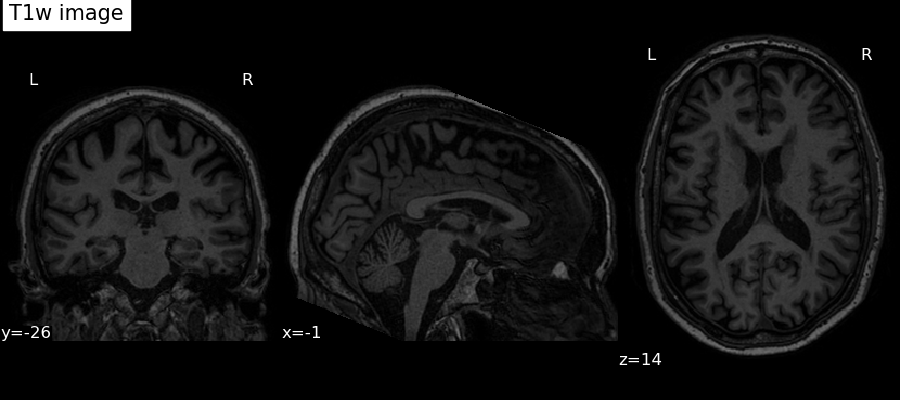

In [4]:
x = ipywidgets.widgets.IntSlider(min=0, max=t1_dims[0], step=1, value=t1_dims[0]//2, description="x")
y = ipywidgets.widgets.IntSlider(min=0, max=t1_dims[1], step=1, value=t1_dims[1]//2, description="y")
z = ipywidgets.widgets.IntSlider(min=0, max=t1_dims[2], step=1, value=t1_dims[2]//2, description="z")

fig = plt.figure(figsize=(9, 4))
#pv_fig2 = plt.figure(figsize=(9, 4))
#print(x,y,z)

mask_options = [('No', 0), ('GM', 1),('WM', 2),('CSF', 3)]
mask_dropdown = ipywidgets.Dropdown(options=mask_options,
                                value=0,
                                description="Mask:")


brain_extract_options = [('No', 0), ('YES', 1)]
brain_extract_dropdown = ipywidgets.Dropdown(options=brain_extract_options,
                                value=0,
                                description="Brain Extracted:")


def show_subject(subject_path, brain_ext, masked, fig, x=0, y=0, z=0):
    subject_id = int(subject_filename[4:])
    
    images_path = [t1w_path, t1_brain_path]
    segs_path = [gm_mask_path, wm_mask_path, csf_mask_path]
    PVs = []
    try:
        #vmin = -threshold
        cmap = "gray"
        fig.clear()
        title = 'T1w image'
        display = nilearn.plotting.plot_anat(images_path[brain_ext], cut_coords=(x-131, y-181, z-116),# cmap=cmap, 
                                   figure=fig, 
                              #vmin=vmin, vmax=threshold,
                                  draw_cross=False, 
                                   title=title)
        if masked > 0:
            display.add_contours(segs_path[masked-1], levels=[.99], colors=["red"])
            
    
    except Exception as e:
        print(str(e))
        #print("Region_analysis file doesn't exist.")

_ = interact(show_subject,
             subject_path=subject_filename,
             brain_ext=brain_extract_dropdown,
             masked=mask_dropdown,
             fig=ipywidgets.fixed(fig), 
             x=x,y=y,z=z)



# ASL Native Space

In [5]:
t1w_filename = 'struc.nii.gz'
brain_filename = 'brain.nii.gz'
gm_filename = 'gm_pv.nii.gz'
wm_filename = 'wm_pv.nii.gz'
pwi_filename = 'pwi.nii.gz'

t1w_path = os.path.join(oxasl_path, 'structural', t1w_filename)
brain_path = os.path.join(oxasl_path, 'structural', brain_filename)
gm_path = os.path.join(oxasl_path, 'structural', gm_filename)
wm_path = os.path.join(oxasl_path, 'structural', wm_filename)
raw_pwi_path = os.path.join(oxasl_path, 'preproc', pwi_filename)
corr_pwi_path = os.path.join(oxasl_path, 'corrected', pwi_filename)



##  Perfusion-weighted Image

In [6]:


slice_slider = ipywidgets.IntSlider(value=6,
                                    min=0,
                                    max=12,
                                    step=1,
                                    description='Slice:',)



def show_difference_map(subject_path, slice_index=6):
    pwi_image_descriptions = ["PWI ", "Distortion and motion corrected PWI"]
    
    try:
        pwis = [raw_pwi_path, corr_pwi_path]
        plt.figure(figsize=(10,4))
        for i in range(2):
            plt.subplot(1, 2, i+1)
            pwi_img = nib.load(pwis[i])
            pwi_arr=pwi_img.get_fdata()
            pwi_arr=np.squeeze(pwi_arr)  
            pwi_slice = pwi_img.dataobj[:,:,slice_index]
            rotated_pwi_slice=np.rot90(pwi_slice)
            plt.imshow(rotated_pwi_slice, cmap='gray')
            #plt.colorbar()
            plt.title(pwi_image_descriptions[i])
        plt.show()
        
        
        
    except Exception as e:
        print(str(e))

        
_ = interact(show_difference_map,
             subject_path=subject_filename,
             slice_index=slice_slider)

interactive(children=(Text(value='sub-1267031', description='subject_path'), IntSlider(value=6, description='S…

## CBF map

In [7]:
def getMasked(image, threshold):
    image = nib.load(image)
    image_arr = image.get_fdata()
    mask = np.zeros(image_arr.shape)
    #num = 0
    for i in range(image_arr.shape[0]):
        for j in range(image_arr.shape[1]):
            for k in range(image_arr.shape[2]):
                if image_arr[i,j,k] > threshold:
                    mask[i,j,k] = 1
                else:
                    mask[i,j,k] = 0
    #print("mask shape:", mask.shape)
    #print("mask pixls:", num)
    mask_image = nib.Nifti1Image(mask, affine=image.affine)
    return mask_image

interactive(children=(Text(value='sub-1267031', description='subject_path'), Dropdown(description='PVC:', opti…

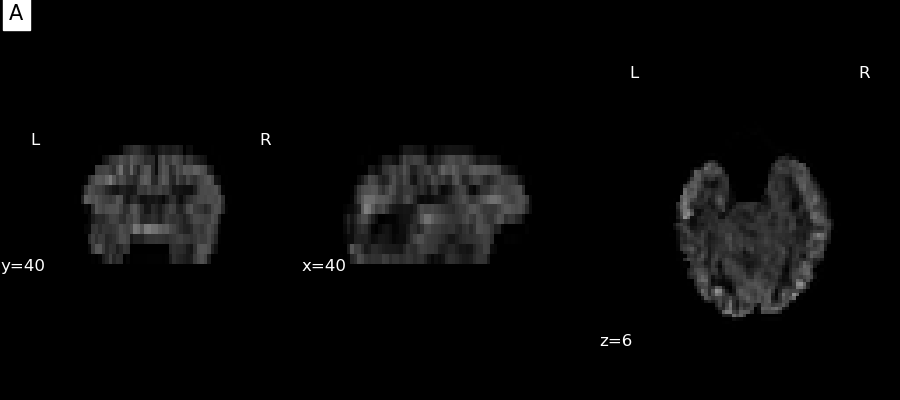

In [8]:
x = ipywidgets.widgets.IntSlider(min=0, max=example_cbf_dims[0], step=1, value=example_cbf_dims[0]//2, description="x")
y = ipywidgets.widgets.IntSlider(min=0, max=example_cbf_dims[1], step=1, value=example_cbf_dims[1]//2, description="y")
z = ipywidgets.widgets.IntSlider(min=0, max=100, step=1, value=example_cbf_dims[2]//2, description="z")



PVC_options = [("No", 'nonpvc'),('Yes', 'pvc')]
PVC_dropdown = ipywidgets.Dropdown(options=PVC_options,
                                value='nonpvc',
                                description="PVC:")



slice_slider = ipywidgets.IntSlider(value=6,
                                    min=0,
                                    max=80,
                                    step=1,
                                    description='Slice:',)

threshold_slider = ipywidgets.FloatSlider(value=0,
                                    min=0,
                                    max=1,
                                    step=0.1,
                                    description='PV Threshold:',)


calib_list = [('voxelwise(default)', 'voxelwise'), ("CSF as ref", 'ref_csf'), ("WM as ref", 'ref_wm')]
Calib_options = calib_list
Calib_dropdown = ipywidgets.Dropdown(options=Calib_options,
                                value='voxelwise',
                                description="Calibration method:")

mask_options = [('No', 0), ('GM', 1),('WM', 2)]
mask_dropdown = ipywidgets.Dropdown(options=mask_options,
                                value=0,
                                description="Mask:")

from nilearn.plotting import plot_glass_brain
from nilearn.image import load_img

fig = plt.figure(figsize=(9, 4))
def show_subject(subject_path, is_pvc, calib_method, masked, threshold, fig, x,y,z):
    
    titles = []
    cbf_map = cbf_maps[is_pvc][calib_method]

    asl_segs_images = []
    pvs_path = [native_gm_pv_path, native_wm_pv_path]
    
    for pv in pvs_path:
        #temp = nib.load(pv).get_fdata()
        mask_pv = getMasked(pv, threshold)
        asl_segs_images.append(mask_pv)
    
    try:
        #cbf_img = nib.load(cbf_map)
        #cbf_img = nilearn.image.load_img(cbf_map)
        #cbf_arr=cbf_img.get_fdata()
        #cbf_arr=np.squeeze(cbf_arr)  
        #cbf_slice = cbf_img.dataobj[:,:,slice_index]
        #rotated_cbf_slice=np.rot90(cbf_slice)
        #plt.imshow(rotated_cbf_slice, cmap='gray')
        #new_image = nib.Nifti1Image(rotated_cbf_slice, affine=np.eye(4))
        fig.clear()
        display = nilearn.plotting.plot_anat(cbf_map, cut_coords=(x,y,z),# cmap=cmap, 
                                  #display_mode='z',
                                   figure=fig, 
                              #vmin=vmin, vmax=threshold,
                                  draw_cross=False, 
                                   title='A')
        if masked > 0:
            #display.add_overlay(pvs_path[masked-1])
            display.add_contours(asl_segs_images[masked-1], levels=[.99], colors=["red"])
            #display.add_contours(native_asl_mask_path, levels=[.99], colors=["red"])
        #nilearn.plotting.view_img(rotated_cbf_slice)
        #display = plot_glass_brain(rotated_cbf_slice, display_mode="lyr")
        #plt.colorbar()
        #plt.title(pwi_image_descriptions[i])
        #plt.show()
        
    except Exception as e:
        print(str(e))
        #print("Region_analysis file doesn't exist.")

_ = interact(show_subject,
             subject_path=subject_filename,
             is_pvc=PVC_dropdown, 
             #slice_index=slice_slider, 
             masked=mask_dropdown,
             x=x,y=y,z=z,
             fig=ipywidgets.fixed(fig),
             threshold = threshold_slider,
             calib_method=Calib_dropdown
             )

## Region Analysis

In [9]:
PVC_options = [("No", 'nonpvc'),('Yes', 'pvc')]
PVC_dropdown = ipywidgets.Dropdown(options=PVC_options,
                                value='nonpvc',
                                description="PVC:")



calib_list = [('voxelwise(default)', 0), ("csf", 1), ("wm", 2)]
Calib_options = calib_list
Calib_dropdown = ipywidgets.Dropdown(options=Calib_options,
                                value=0,
                                description="Calibration method:")

def get_csv_by_index(subject_path, pvc_index, calib_index):
    calib_method = ['calib_voxelwise', 'calib_refregion_csf', 'calib_refregion_wm']
    
    nonpvc_region_analysis_dir = os.path.join(oxasl_path, 'output', 'native', calib_method[calib_index])
    pvc_region_analysis_dir = os.path.join(oxasl_path, 'output_pvcorr', 'native', calib_method[calib_index])
    
    perfusion_df = pd.read_csv(os.path.join(nonpvc_region_analysis_dir, 'roi_stats.csv'))
    perfusion_gm_df = pd.read_csv(os.path.join(pvc_region_analysis_dir, 'roi_stats_gm.csv'))
    perfusion_wm_df = pd.read_csv(os.path.join(pvc_region_analysis_dir, 'roi_stats_wm.csv'))

    perfusion_df['name'].replace('80%+GM', 'GM', inplace=True)
    perfusion_df['name'].replace('90%+WM', 'WM', inplace=True)
    perfusion_df['name'].replace('Right_Cerebral_White_Matter_80%+', 'RCWM', inplace=True)
    perfusion_df['name'].replace('Left_Cerebral_White_Matter_80%+', 'LCWM', inplace=True)
    perfusion_gm_df['name'].replace('80%+GM', 'GM', inplace=True)
    perfusion_wm_df['name'].replace('90%+WM', 'WM', inplace=True)
    perfusion_wm_df['name'].replace('Right_Cerebral_White_Matter_80%+', 'RCWM', inplace=True)
    perfusion_wm_df['name'].replace('Left_Cerebral_White_Matter_80%+', 'LCWM', inplace=True)

    
    roi_names = ['GM','WM', 'RCWM', 'RCWM', 'LCWM', 'VBA', 'RICA', 'LICA']
    roi_gm_names = ['GM', 'VBA', 'RICA', 'LICA']
    roi_wm_names = ['WM', 'RCWM', 'LCWM',]

    roi_indices = perfusion_df.index[perfusion_df['name'].isin(roi_names)].tolist()
    roi_gm_indices = perfusion_gm_df.index[perfusion_gm_df['name'].isin(roi_gm_names)].tolist()
    roi_wm_indices = perfusion_wm_df.index[perfusion_wm_df['name'].isin(roi_wm_names)].tolist()


    roi_stats_df = perfusion_df.iloc[roi_indices].reset_index(drop=True)
    roi_gm_stats_df = perfusion_gm_df.iloc[roi_gm_indices]
    roi_wm_stats_df = perfusion_wm_df.iloc[roi_wm_indices]
    roi_pvc_stats_df = pd.concat([roi_gm_stats_df, roi_wm_stats_df], axis=0).reset_index(drop=True)

    roi_stats = {}
    roi_stats['nonpvc'] = roi_stats_df
    roi_stats['pvc'] = roi_pvc_stats_df

    for perf in roi_stats.values():
        perf['SpCov'] = perf[['Std', 'Mean']].apply(lambda x: x['Std'] * 100 / x['Mean'], axis=1).round(2)
    
    ######Vascular Territory
    LICA_RICA_Ratio_nonPVC = {'LICA':roi_stats_df[roi_stats_df['name'] == 'LICA']['Mean'].to_numpy(),
                              'RICA':roi_stats_df[roi_stats_df['name'] == 'RICA']['Mean'].to_numpy(), 
                              "L/R":roi_stats_df[roi_stats_df['name'] == 'LICA']['Mean'].to_numpy()/roi_stats_df[roi_stats_df['name'] == 'RICA']['Mean'].to_numpy()}
    pd_LICA_RICA_Ratio_nonPVC = pd.DataFrame(data=LICA_RICA_Ratio_nonPVC).round(2)
    
    LICA_RICA_Ratio_PVC = {'LICA':roi_gm_stats_df[roi_gm_stats_df['name'] == 'LICA']['Mean'].to_numpy(),
                              'RICA':roi_gm_stats_df[roi_gm_stats_df['name'] == 'RICA']['Mean'].to_numpy(), 
                              "L/R":roi_gm_stats_df[roi_gm_stats_df['name'] == 'LICA']['Mean'].to_numpy()/roi_gm_stats_df[roi_gm_stats_df['name'] == 'RICA']['Mean'].to_numpy()}
    pd_LICA_RICA_Ratio_PVC = pd.DataFrame(data=LICA_RICA_Ratio_PVC).round(2)
    
    pd_LICA_RICA_Ratio = {'nonpvc':pd_LICA_RICA_Ratio_nonPVC, 'pvc':pd_LICA_RICA_Ratio_PVC}
    ######Vascular Territory

    ######Cerebral white matter
    Cerebral_WM_Ratio_nonPVC = {'LCWM':roi_stats_df[roi_stats_df['name'] == 'LCWM']['Mean'].to_numpy(), 
                             'RCWM':roi_stats_df[roi_stats_df['name'] == 'RCWM']['Mean'].to_numpy(), 
                             "L/R":roi_stats_df[roi_stats_df['name'] == 'LCWM']['Mean'].to_numpy()/roi_stats_df[roi_stats_df['name'] == 'RCWM']['Mean'].to_numpy()}
    pd_Cerebral_WM_Ratio_nonPVC = pd.DataFrame(data=Cerebral_WM_Ratio_nonPVC).round(2)
    
    Cerebral_WM_Ratio_PVC = {'LCWM':roi_wm_stats_df[roi_wm_stats_df['name'] == 'LCWM']['Mean'].to_numpy(), 
                                'RCWM':roi_wm_stats_df[roi_wm_stats_df['name'] == 'RCWM']['Mean'].to_numpy(), 
                                "L/R":roi_wm_stats_df[roi_wm_stats_df['name'] == 'LCWM']['Mean'].to_numpy()/roi_wm_stats_df[roi_wm_stats_df['name'] == 'RCWM']['Mean'].to_numpy()}
    pd_Cerebral_WM_Ratio_PVC = pd.DataFrame(data=Cerebral_WM_Ratio_PVC).round(2)

    pd_Cerebral_Ratio = {'nonpvc':pd_Cerebral_WM_Ratio_nonPVC, 'pvc':pd_Cerebral_WM_Ratio_PVC}

    ######Cerebral white matter

    ######GM/WM Ratio
    GM_WM_Ratio_nonPVC = {'GM':roi_stats_df[roi_stats_df['name'] == 'GM']['Mean'].to_numpy(), 
                          'WM':roi_stats_df[roi_stats_df['name'] == 'WM']['Mean'].to_numpy(), 
                          "GM/WM":roi_stats_df[roi_stats_df['name'] == 'GM']['Mean'].to_numpy()/roi_stats_df[roi_stats_df['name'] == 'WM']['Mean'].to_numpy()}
    pd_GM_WM_Ratio_nonPVC = pd.DataFrame(data=GM_WM_Ratio_nonPVC).round(2)
    
    GM_WM_Ratio_PVC = {'GM':roi_gm_stats_df[roi_gm_stats_df['name'] == 'GM']['Mean'].to_numpy(), 
                       'WM':roi_wm_stats_df[roi_wm_stats_df['name'] == 'WM']['Mean'].to_numpy(), 
                       "GM/WM":roi_gm_stats_df[roi_gm_stats_df['name'] == 'GM']['Mean'].to_numpy()/roi_wm_stats_df[roi_wm_stats_df['name'] == 'WM']['Mean'].to_numpy()}
    pd_GM_WM_Ratio_PVC = pd.DataFrame(data=GM_WM_Ratio_PVC).round(2)

    pd_GM_WM_Ratio = {'nonpvc':pd_GM_WM_Ratio_nonPVC, 'pvc':pd_GM_WM_Ratio_PVC}
    ######GM/WM Ratio
    
    return {'roi':roi_stats, 
            'VT_R':pd_LICA_RICA_Ratio,
            'CWM_R':pd_Cerebral_Ratio,
            'GM_WM_R':pd_GM_WM_Ratio}


def mean_perfusion_barchart(data):
    fig=plt.figure(figsize=(5,4))
    ax= fig.add_subplot(1,1,1)
    plt.xticks((0, 1, 2, 3, 4, 5, 6), ('GM','WM', 'RCWM','LCWM', 'RICA', 'LICA', 'VBA'))
    plt.title("Regional CBF")
    #names = ['10%+GM', '80%+GM', '10%+WM', '90%+WM', 'RC80%WM','LC80%WM', 'RICA', 'LICA', 'VBA']
    #plt.xlabel('Region')
    ax.set_ylabel('CBF (ml/100g/min)')
    #data.set_index(data.columns[0], inplace=True)
    #plt.xticks(fontsize = 8, rotation=55)
    plt.xticks(fontsize = 8)
    #data['Mean'].transpose().plot(kind='bar')
    #print(data.columns)
    #print(data['name'].values.tolist())
    #print(data['Mean'].transpose().to_numpy())
    ax.bar(data['name'].transpose(), data['Mean'].transpose().to_numpy(), width=0.5)
    plt.show()

    
def show_table(subject_path, pvc_index, calib_index):
    #subject_id = int(subject_name[4:])
 
    try:
        pd_roi_stats= get_csv_by_index(subject_path, pvc_index, calib_index)
        #print(pd_list[pvc_index])
        
        display(pd_roi_stats['roi'][pvc_index])
        display(pd_roi_stats['VT_R'][pvc_index])
        display(pd_roi_stats['CWM_R'][pvc_index])
        display(pd_roi_stats['GM_WM_R'][pvc_index])
        mean_perfusion_barchart(pd_roi_stats['roi'][pvc_index])
        
    except Exception as e:
        print(e)
        #print("Region_analysis file doesn't exist.")

_ = interact(show_table,
             subject_path=subject_filename, 
             pvc_index=PVC_dropdown, 
             calib_index=Calib_dropdown)



interactive(children=(Text(value='sub-1267031', description='subject_path'), Dropdown(description='PVC:', opti…

## Motion estimates

In [10]:
oxasl_report_path = os.path.join(oxasl_path, 'report')
motion_trans_path = os.path.join(oxasl_report_path, '_images', 'moco_trans.png')
motion_rot_path = os.path.join(oxasl_report_path, '_images', 'moco_rot.png')


def show_difference_map():
    titles = ["Translation series", "Rotation series"]
    moco_series_paths = [motion_trans_path, motion_rot_path]
    try:
       
        plt.figure(figsize=(10,8))
        for i in range(2):
            plt.subplot(2, 1, i+1)
            moco_series = Image.open(moco_series_paths[i])
            plt.imshow(moco_series)
            plt.title(titles[i]) 
            plt.axis('off')
        plt.show()
            
    except Exception as e:
        print(str(e))
        print("Region_analysis file doesn't exist.")

_ = interact(show_difference_map)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

# Standard Space

In [11]:
std_t1w_path = os.path.join(oxasl_path, 'reg', 'strucref.nii.gz')
std_template_path = os.path.join(oxasl_path, 'reg', 'stdref.nii.gz')
std_cbf_path = os.path.join(oxasl_path, 'output', 'std', 'calib_voxelwise','perfusion.nii.gz')

std_t1_img = nib.load(t1w_path)
std_t1_data = std_t1_img.get_fdata()
std_t1_dims = std_t1_img.shape


interactive(children=(Text(value='sub-1267031', description='subject_path'), IntSlider(value=130, description=…

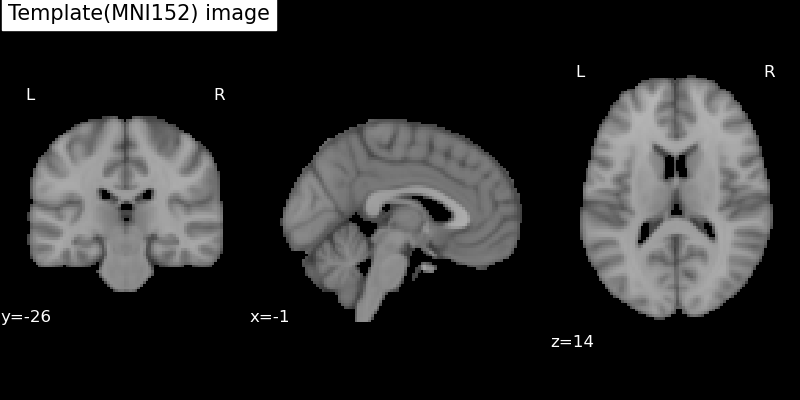

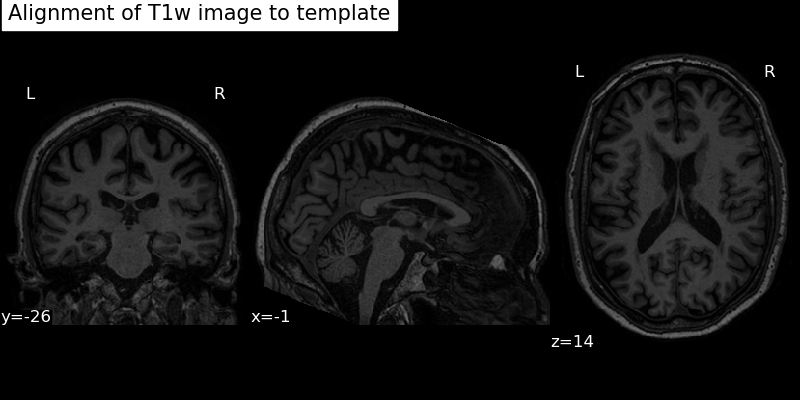

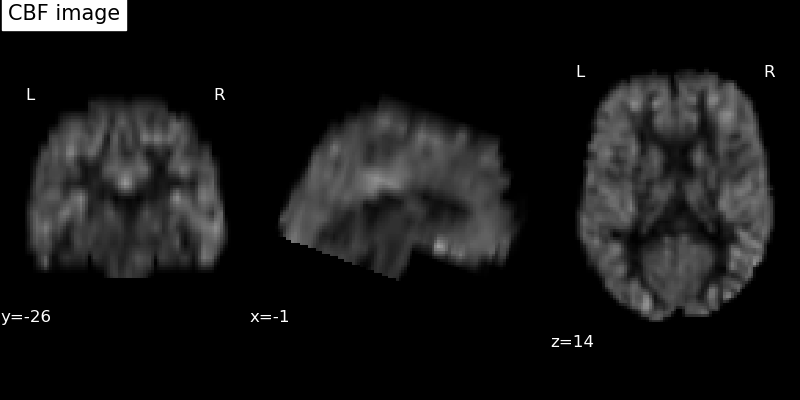

In [12]:
x = ipywidgets.widgets.IntSlider(min=0, max=std_t1_dims[0], step=1, value=std_t1_dims[0]//2, description="x")
y = ipywidgets.widgets.IntSlider(min=0, max=std_t1_dims[1], step=1, value=std_t1_dims[1]//2, description="y")
z = ipywidgets.widgets.IntSlider(min=0, max=std_t1_dims[2], step=1, value=std_t1_dims[2]//2, description="z")

fig = plt.figure(figsize=(8, 4))
fig2 = plt.figure(figsize=(8, 4))
fig3 = plt.figure(figsize=(8, 4))
#print(x,y,z)

mask_options = [('No', 0), ('GM', 1),('WM', 2),('CSF', 3)]
mask_dropdown = ipywidgets.Dropdown(options=mask_options,
                                value=0,
                                description="Mask:")

t1_template_options = [('T1w', 0), ('Template', 1)]
t1_template_dropdown = ipywidgets.Dropdown(options=t1_template_options,
                                value=0,
                                description="Image type:")

brain_extract_options = [('No', 0), ('YES', 1)]
brain_extract_dropdown = ipywidgets.Dropdown(options=brain_extract_options,
                                value=0,
                                description="Brain Extracted:")


def show_subject(subject_path, fig, fig2, fig3, x=0, y=0, z=0):
    subject_id = int(subject_filename[4:])
    title2 = 'Alignment of T1w image to template'
    title1 = 'Template(MNI152) image'
    title3 = 'CBF image'
    try:
        #vmin = -threshold
        cmap = "gray"
        fig.clear()
        fig2.clear()
        fig3.clear()
        display = nilearn.plotting.plot_anat(std_template_path, cut_coords=(x-131, y-181, z-116),# cmap=cmap, 
                                   figure=fig, 
                              #vmin=vmin, vmax=threshold,
                                  draw_cross=False, 
                                   title=title1)

        display = nilearn.plotting.plot_anat(std_t1w_path, cut_coords=(x-131, y-181, z-116),# cmap=cmap, 
                                   figure=fig2, 
                              #vmin=vmin, vmax=threshold,
                                  draw_cross=False, 
                                   title=title2)

        display = nilearn.plotting.plot_anat(std_cbf_path, cut_coords=(x-131, y-181, z-116),# cmap=cmap, 
                                   figure=fig3, 
                              #vmin=vmin, vmax=threshold,
                                  draw_cross=False, 
                                   title=title3)
        #if masked > 0:
        #    display.add_contours(segs_path[masked-1], levels=[.99], colors=["red"])
            
    
    except Exception as e:
        print(str(e))
        #print("Region_analysis file doesn't exist.")

_ = interact(show_subject,
             subject_path=subject_filename,
             #brain_ext=brain_extract_dropdown,
             #masked=mask_dropdown,
             #image_type=t1_template_dropdown,
             fig=ipywidgets.fixed(fig), 
             fig2 = ipywidgets.fixed(fig2), 
             fig3 = ipywidgets.fixed(fig3), 
             x=x,y=y,z=z)

